In [ ]:
# Librerie per la manipolazione dei dati
import numpy as np                
import pandas as pd               
import seaborn as sns             
import matplotlib.pyplot as plt    

# Modulo personalizzato per l'ETL
from ETL import ETL                

# Riduzione dimensionale e pre-processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Algoritmi di clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

# Metriche di valutazione dei cluster
from sklearn.metrics import silhouette_samples, silhouette_score

# Algoritmi per il numero ottimale di cluster
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df = pd.read_csv('dataset/flights.csv')

In [3]:
df = ETL(df)

# PCA

In [5]:
df.columns

Index(['OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'DEP_DELAY',
       'TAXI_OUT', 'TAXI_IN', 'ARR_DELAY', 'CANCELLED', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'FL_MON', 'FL_DAY', 'FL_YEAR', 'FL_DOW', 'CRS_DEP_TIME_HOUR',
       'CRS_DEP_TIME_MIN', 'DEP_TIME_HOUR', 'DEP_TIME_MIN', 'WHEELS_OFF_HOUR',
       'WHEELS_OFF_MIN', 'WHEELS_ON_HOUR', 'WHEELS_ON_MIN',
       'CRS_ARR_TIME_HOUR', 'CRS_ARR_TIME_MIN', 'ARR_TIME_HOUR',
       'ARR_TIME_MIN', 'ACT_TO_CRS_RATIO', 'CANCELLATION_REASON'],
      dtype='object')

In [6]:
filtered_data = df[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)]
data = filtered_data[['DEP_DELAY', 'ARR_DELAY', 'TAXI_OUT', 
                    'TAXI_IN','ACT_TO_CRS_RATIO','AIR_TIME']]

# Imputazione con la media
data = data.fillna(data.mean())

# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [7]:
pca = PCA(n_components=2)  # Sostituisci 2 con il numero di componenti che vuoi
pca_result = pca.fit_transform(data_scaled)

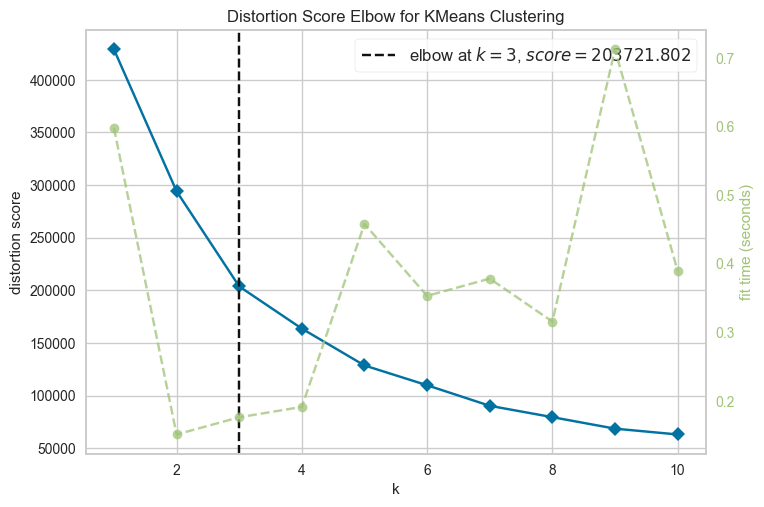

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
# Creazione del modello KMeans
model = KMeans(random_state=42)

# Utilizzo di KElbowVisualizer per determinare il numero ottimale di cluster
visualizer = KElbowVisualizer(model, k=(1, 11), metric='distortion', timings=True)

# Fit dei dati e visualizzazione del grafico
visualizer.fit(pca_result)
visualizer.show()

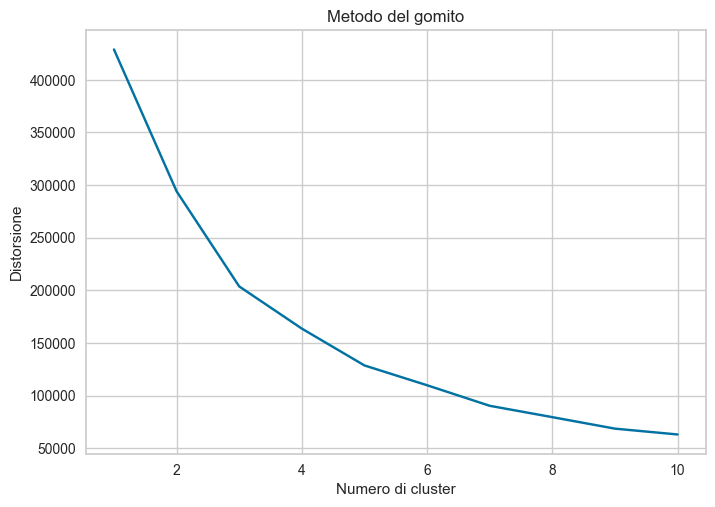

In [9]:
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_result)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 11), distortions)
plt.xlabel('Numero di cluster')
plt.ylabel('Distorsione')
plt.title('Metodo del gomito')
plt.show()

Numero ottimale di cluster secondo il metodo del gomito: 3


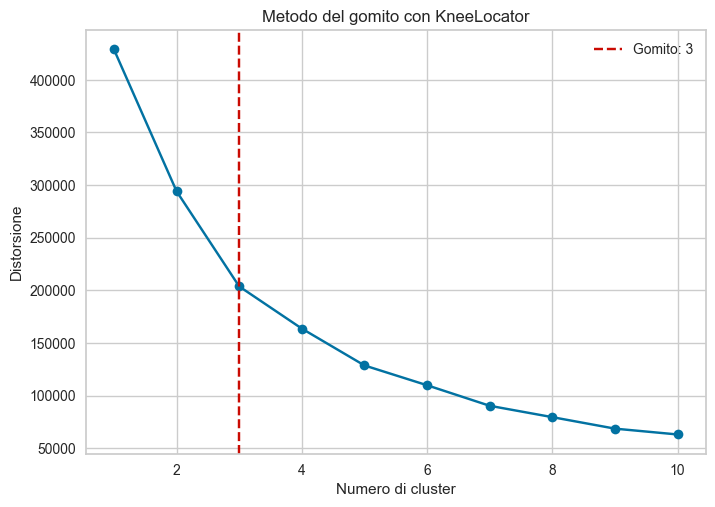

In [10]:
# Calcolare il "gomito"
knee = KneeLocator(range(1, 11), distortions, curve="convex", direction="decreasing")

# Stampare e visualizzare il risultato
print(f"Numero ottimale di cluster secondo il metodo del gomito: {knee.knee}")

# Modificare il grafico per evidenziare il gomito
plt.plot(range(1, 11), distortions, marker='o')
plt.axvline(x=knee.knee, color='r', linestyle='--', label=f"Gomito: {knee.knee}")
plt.xlabel('Numero di cluster')
plt.ylabel('Distorsione')
plt.title('Metodo del gomito con KneeLocator')
plt.legend()
plt.show()


In [11]:
# Applica K-Means ai risultati della PCA
kmeans = KMeans(n_clusters=3, random_state=0)  # Imposta n_clusters al numero desiderato
kmeans.fit(pca_result)
clusters = kmeans.predict(pca_result)
filtered_data['Cluster']= clusters

C:\Users\dswal\AppData\Local\Temp\ipykernel_22792\4117755696.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Cluster']= clusters


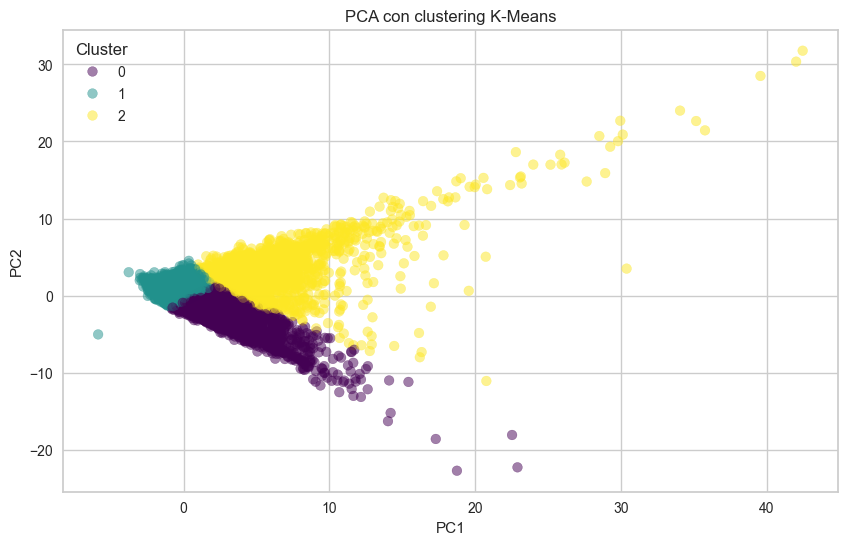

In [12]:
# Visualizza il grafico della PCA con i cluster di K-Means
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clustering K-Means')
plt.legend(*scatter.legend_elements(), title="Cluster", loc='best')
plt.show()

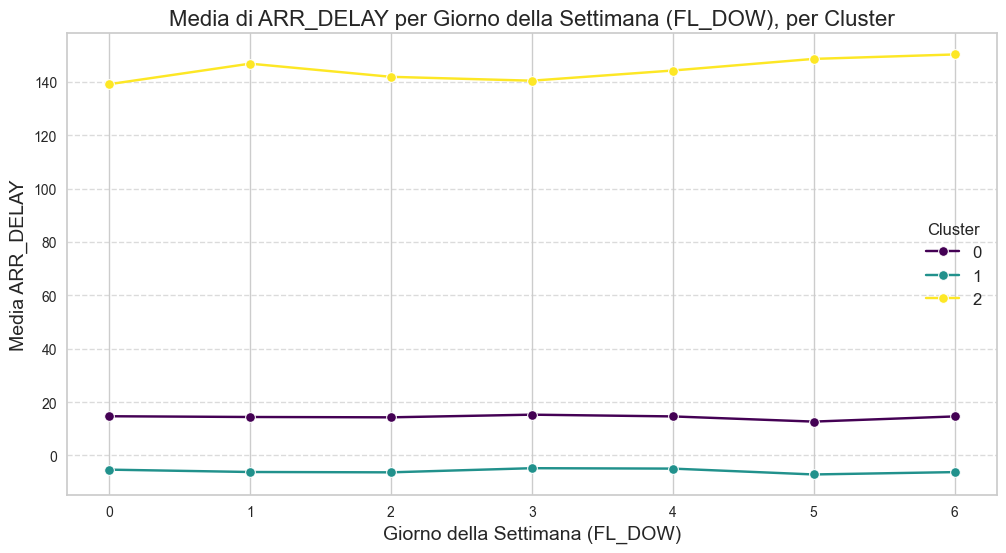

In [13]:
# Calcola la media e la deviazione standard per ARR_DELAY per cluster e FL_DOW
grouped_data = filtered_data.groupby(['FL_DOW', 'Cluster'])['ARR_DELAY'].agg(['mean', 'std']).reset_index()

# Crea il grafico lineplot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_data,
    x='FL_DOW',
    y='mean',
    hue='Cluster',
    marker='o',
    palette='viridis',
    err_style="bars",  # Visualizza le barre di errore
    err_kws={'capsize': 5}  # Dimensione dei "tappi" delle barre di errore
)

# Aggiungi titolo e etichette
plt.title('Media di ARR_DELAY per Giorno della Settimana (FL_DOW), per Cluster', fontsize=16)
plt.xlabel('Giorno della Settimana (FL_DOW)', fontsize=14)
plt.ylabel('Media ARR_DELAY', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostra il grafico
plt.show()

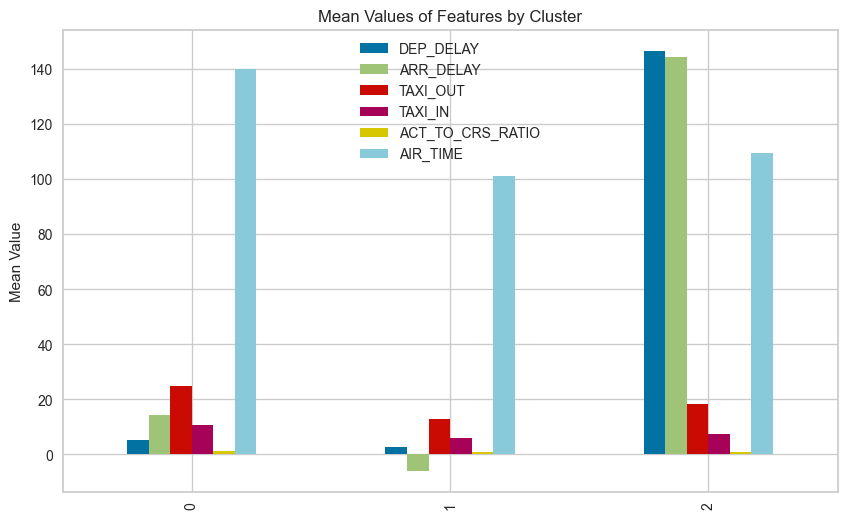

In [14]:
cluster_means = data.groupby(kmeans.labels_).mean()
cluster_means.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Values of Features by Cluster')
plt.ylabel('Mean Value')
plt.show()


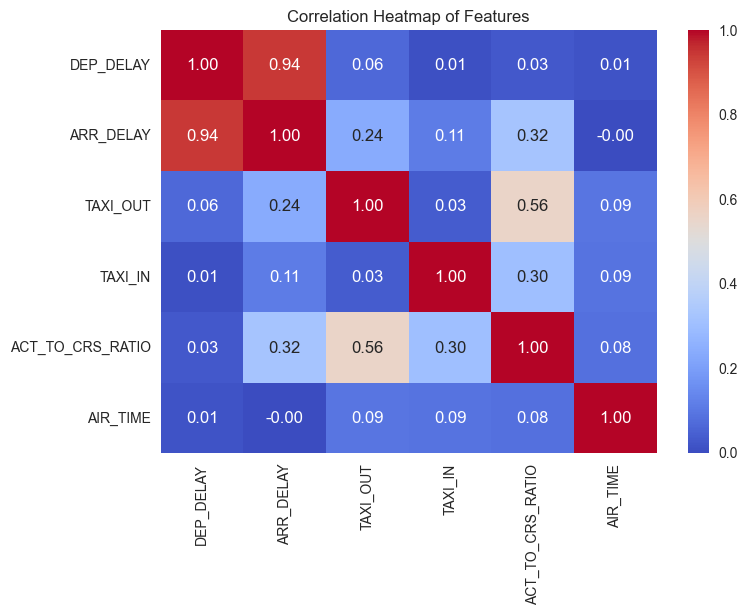

In [15]:
import seaborn as sns
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()


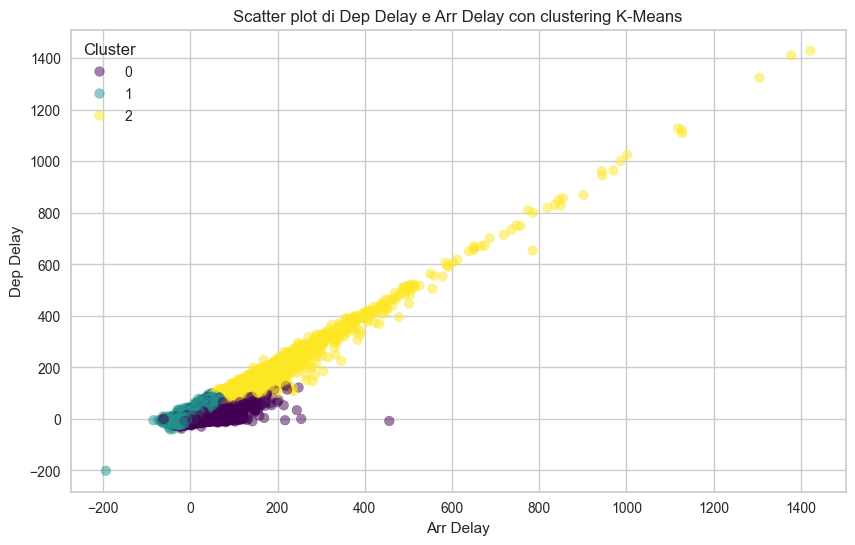

In [16]:
# Visualizza il grafico scatter di dep_delay e arr_delay con i cluster di K-Means
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['ARR_DELAY'], data['DEP_DELAY'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Arr Delay')
plt.ylabel('Dep Delay')
plt.title('Scatter plot di Dep Delay e Arr Delay con clustering K-Means')

# Aggiungi una legenda per i cluster
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

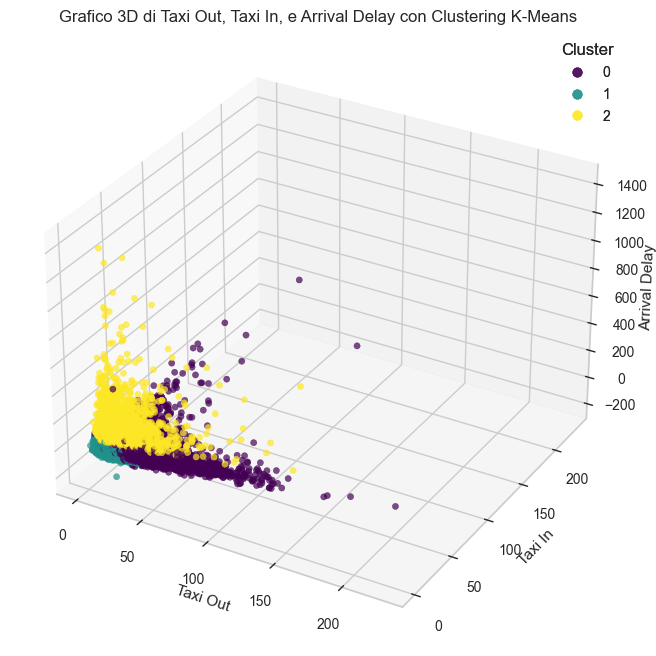

In [17]:
# Creazione della figura 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Creazione dello scatter plot 3D
scatter = ax.scatter(
    data['TAXI_OUT'], 
    data['TAXI_IN'], 
    data['ARR_DELAY'], 
    c=clusters, 
    cmap='viridis', 
    alpha=0.7
)

# Etichette degli assi
ax.set_xlabel('Taxi Out')
ax.set_ylabel('Taxi In')
ax.set_zlabel('Arrival Delay')

# Titolo
ax.set_title('Grafico 3D di Taxi Out, Taxi In, e Arrival Delay con Clustering K-Means')

# Legenda
legend = ax.legend(*scatter.legend_elements(), title="Cluster", loc="best")
fig.add_artist(legend)

# Mostra il grafico
plt.show()


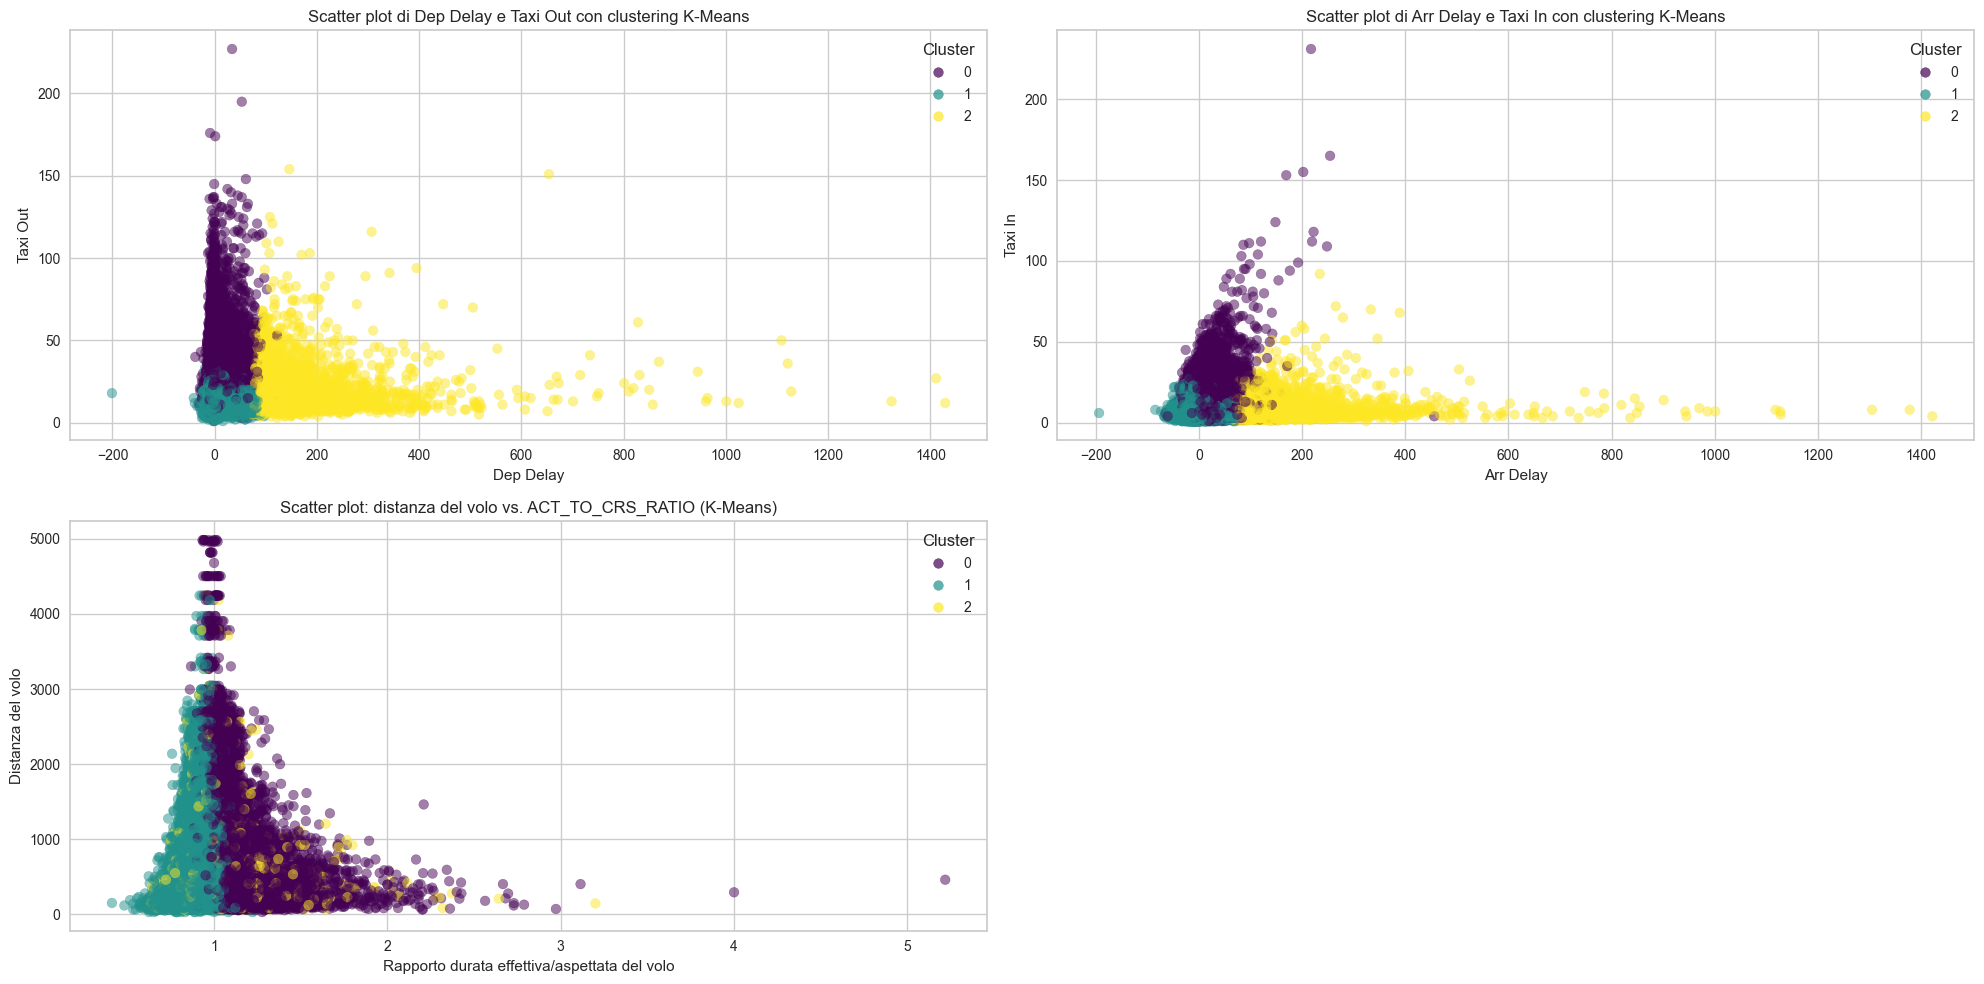

In [18]:
# Creazione della figura con due subplot
plt.figure(figsize=(20, 10))

# Primo grafico
plt.subplot(2, 2, 1)
plt.scatter(data['DEP_DELAY'], data['TAXI_OUT'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Dep Delay')
plt.ylabel('Taxi Out')
plt.title('Scatter plot di Dep Delay e Taxi Out con clustering K-Means')
plt.legend(*scatter.legend_elements(), title="Cluster")

# Secondo grafico
plt.subplot(2, 2, 2)
plt.scatter(data['ARR_DELAY'], data['TAXI_IN'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Arr Delay')
plt.ylabel('Taxi In')
plt.title('Scatter plot di Arr Delay e Taxi In con clustering K-Means')
plt.legend(*scatter.legend_elements(), title="Cluster")

# Terzo grafico
plt.subplot(2, 2, 3)
plt.scatter(data['ACT_TO_CRS_RATIO'], filtered_data['DISTANCE'], c=clusters, cmap='viridis', alpha=0.5)

# Etichette e titolo
plt.xlabel('Rapporto durata effettiva/aspettata del volo')
plt.ylabel('Distanza del volo')
plt.title('Scatter plot: distanza del volo vs. ACT_TO_CRS_RATIO (K-Means)')
plt.legend(*scatter.legend_elements(), title="Cluster")

# Mostra il grafico affiancato
plt.tight_layout()
plt.show()


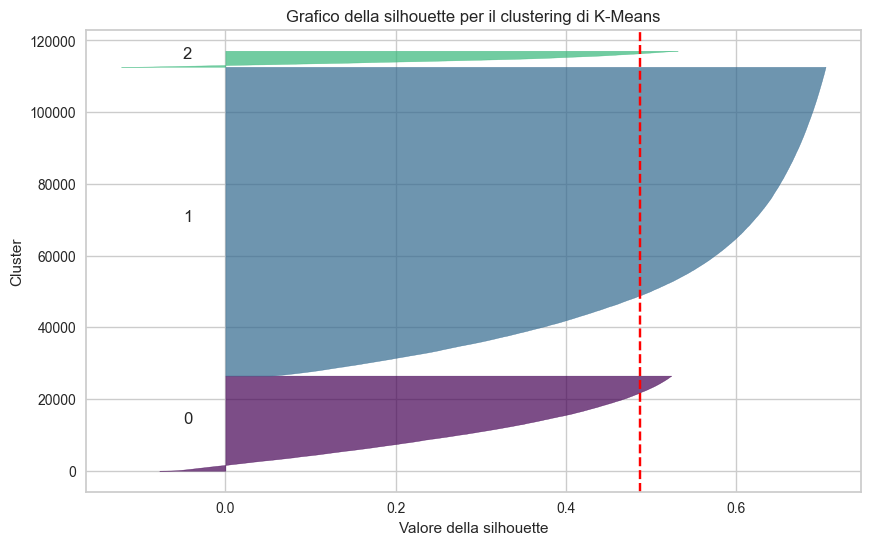

In [19]:
# Calcola i campioni di silhouette per ciascun punto
silhouette_vals = silhouette_samples(pca_result, clusters)

# Calcola la silhouette media per l'intero clustering
silhouette_avg = silhouette_score(pca_result, clusters)

# Visualizza il grafico della silhouette
plt.figure(figsize=(10, 6))
y_lower = 10
n_clusters = len(set(clusters))

for i in range(n_clusters):
    # Accumula i valori di silhouette del cluster i e ordina i valori
    ith_cluster_silhouette_vals = silhouette_vals[clusters == i]
    ith_cluster_silhouette_vals.sort()
    
    y_upper = y_lower + len(ith_cluster_silhouette_vals)
    color = plt.cm.viridis(i / n_clusters)
    
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Etichetta ogni silhouette con il rispettivo cluster al centro del grafico
    plt.text(-0.05, y_lower + 0.5 * len(ith_cluster_silhouette_vals), str(i))
    
    # Aggiorna y_lower per il prossimo cluster
    y_lower = y_upper + 10

# Linea verticale per la silhouette media dell'intero clustering
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.xlabel("Valore della silhouette")
plt.ylabel("Cluster")
plt.title("Grafico della silhouette per il clustering di K-Means")
plt.show()

# DBSCAN

In [20]:
filtered_data = df[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)]
data = filtered_data[['DEP_DELAY', 'ARR_DELAY', 'TAXI_OUT', 
                    'TAXI_IN','ACT_TO_CRS_RATIO','AIR_TIME']]

# Imputazione con la media
data = data.fillna(data.mean())

# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=2)  # Sostituisci 2 con il numero di componenti che vuoi
pca_result = pca.fit_transform(data_scaled)

# Calcola le distanze dai vicini più prossimi
k = 7 # Imposta 'k' uguale a min_samples.+-
neigh = NearestNeighbors(n_neighbors=k)
neighbors = neigh.fit(pca_result)
distances, indices = neighbors.kneighbors(pca_result)

# Ordina le distanze in ordine crescente
distances = np.sort(distances[:, 1], axis=0)  # Prendi solo la seconda colonna per la distanza dal 2° vicino

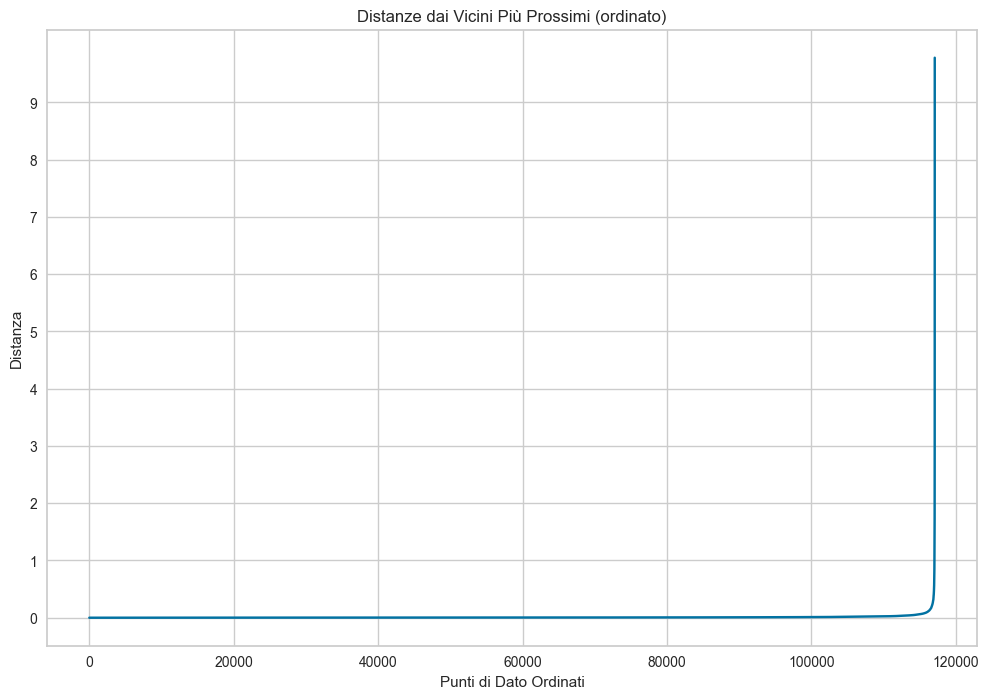

In [21]:
# Traccia il grafico per trovare il valore di epsilon
plt.figure(figsize=(12,8))
plt.plot(distances)
plt.title('Distanze dai Vicini Più Prossimi (ordinato)')
plt.xlabel('Punti di Dato Ordinati')
plt.ylabel('Distanza')
plt.grid(True)

y_ticks = np.arange(0, np.max(distances))
plt.yticks(y_ticks)

plt.show()

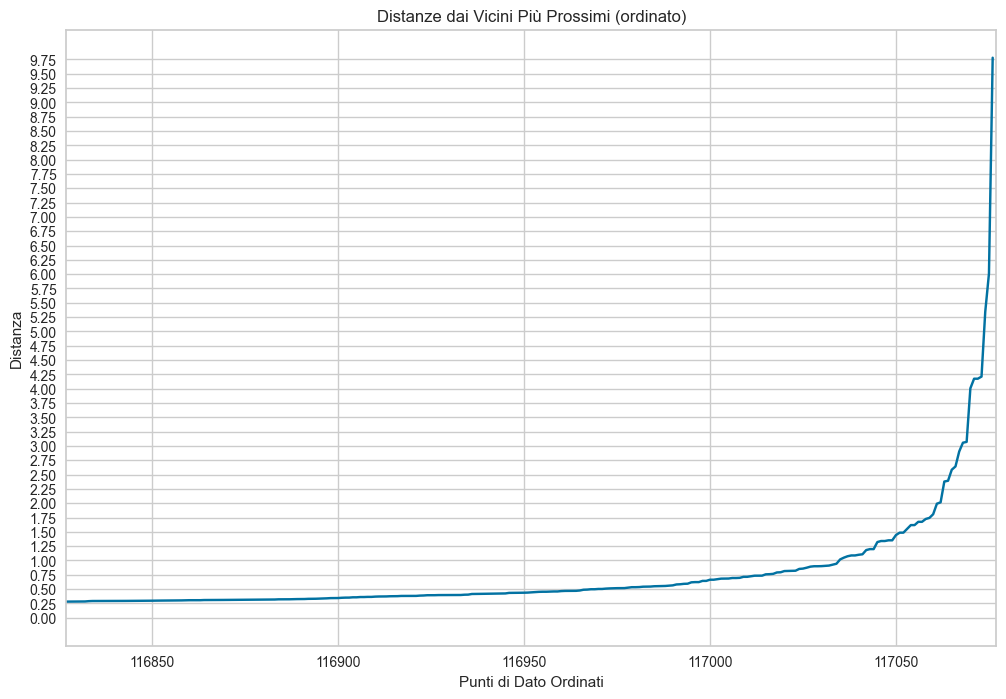

In [22]:
# Traccia il grafico per trovare il valore di epsilon
plt.figure(figsize=(12,8))
plt.plot(distances)
plt.title('Distanze dai Vicini Più Prossimi (ordinato)')
plt.xlabel('Punti di Dato Ordinati')
plt.ylabel('Distanza')
plt.grid(True)

# Aggiungi i tick ogni 0.1 sull'asse y
y_ticks = np.arange(0, np.max(distances), 0.25)  # passo di 0.1
plt.yticks(y_ticks)

# Fai lo zoom negli ultimi 400 punti sull'asse delle x
plt.xlim(len(distances)-250, len(distances))  # zoom sugli ultimi 400 punti

plt.show()


In [23]:
# Calcola la differenza tra i valori consecutivi (prima derivata)
delta_distances = np.diff(distances)

# Calcola la differenza tra le variazioni consecutive (seconda derivata)
delta_delta_distances = np.diff(delta_distances)

# Trova l'indice in cui la variazione della variazione è massima
epsilon_index = np.argmax(np.abs(delta_delta_distances)) + 1  # +1 per allineare l'indice originale

# Epsilon è il valore della distanza al punto del massimo cambiamento
epsilon = distances[epsilon_index]
print(f"Epsilon calcolato: {epsilon}")

Epsilon calcolato: 6.010461359681483


In [24]:
#distanze normali

kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")

# Epsilon è il valore della distanza al punto del ginocchio
epsilon = distances[kneedle.elbow]
print(f"Epsilon calcolato: {epsilon}")

Epsilon calcolato: 0.4351542297447345


In [25]:
#distanze smussate

# Esegui una media mobile per smussare i dati
window_size = 2  # ad esempio, 50 punti
smoothed_distances = np.convolve(distances, np.ones(window_size)/window_size, mode='valid')

kneedle = KneeLocator(range(len(smoothed_distances)), smoothed_distances, curve="convex", direction="increasing")

# Epsilon è il valore della distanza al punto del ginocchio
epsilon = distances[kneedle.elbow]
print(f"Epsilon calcolato: {epsilon}")

Epsilon calcolato: 0.2525929408382429


In [26]:
# Esegui DBSCAN sui risultati della PCA
dbscan = DBSCAN(eps=epsilon, min_samples=k)  # Imposta eps e min_samples in base ai tuoi dati
dbscan_labels = dbscan.fit_predict(pca_result)

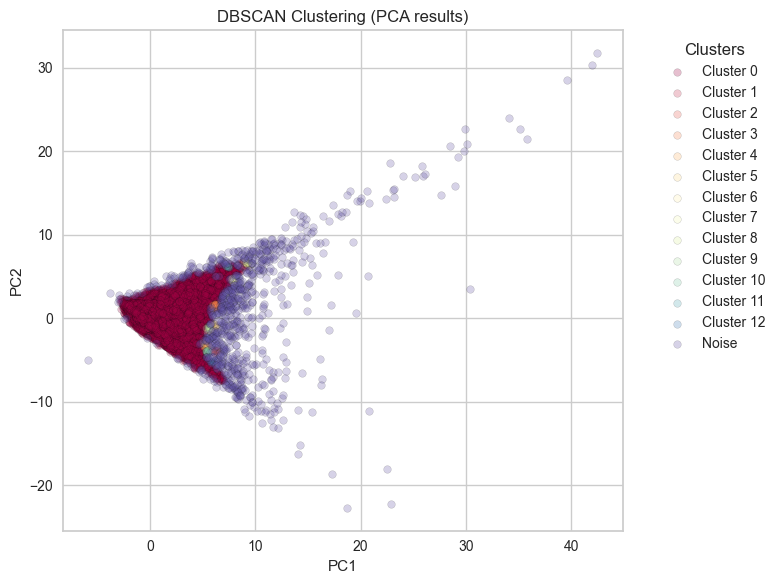

In [27]:
# Crea un grafico dei dati dopo l'applicazione della PCA
plt.figure(figsize=(8, 6))

# DBSCAN assegna -1 ai punti considerati "rumore"
unique_labels = set(dbscan_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i, col in zip(unique_labels, colors):
    class_member_mask = (dbscan_labels == i)
    xy = pca_result[class_member_mask]
    
    plt.scatter(xy[:, 0], xy[:, 1], s=30, c=[col], label=f"Cluster {i}" if i != -1 else 'Noise', edgecolors='k', alpha=0.25)

plt.title('DBSCAN Clustering (PCA results)')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Aggiusta la posizione e la dimensione della legenda per migliorarne la leggibilità
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title="Clusters")

plt.tight_layout()  # Per evitare che la legenda si sovrapponga
plt.show()
